In [6]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OMP_MAX_ACTIVE_LEVELS"] = "1"

import pyreadr
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.preprocessing import StandardScaler
import scipy.cluster.hierarchy as sch

import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from sklearn.mixture import GaussianMixture
from scipy.optimize import minimize
from scipy.stats import chi2
from tqdm import tqdm  # import tqdm for progress bar
import warnings

from sklearn.decomposition import PCA
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize, approx_fprime
from matplotlib.patches import Ellipse
import matplotlib.patches as patches

# ADNI data -- Alzheimer’s Disease Neuroimaging Initiative

ADNI Data group: https://groups.google.com/g/adni-data

Download data: `ADNIMERGE_0.0.1.tar.gz`
Downloads --- Study Info --- Data&Database --- ADNIMERGE - Key ADNI tables merged into one table - Packages for R [ADNI1,GO,2]||


| Label        | Meaning                                             |
| ------------ | --------------------------------------------------- |
| **CN**       | Cognitively Normal (healthy control)                |
| **MCI**      | Mild Cognitive Impairment (prodromal AD)            |
| **Dementia** | Dementia due to Alzheimer’s Disease or other causes |


Important Features

|Features|Meaning|
|---|---|
|**AGE**|Subject’s age at baseline visit|
|**PTEDUCAT**|Years of education|
|**APOE4**|Number of APOE ε4 alleles (genetic risk factor for AD)|
|**MMSE**|Mini-Mental State Examination score (cognitive test)|
|**ADAS13**|Alzheimer’s Disease Assessment Scale – cognitive subscale|
|**CDRSB**|Clinical Dementia Rating Sum of Boxes (severity of dementia)|
|**FDG**|FDG-PET standardized uptake value (glucose metabolism in brain)|
|**AV45**|AV45-PET standardized uptake value (amyloid deposition)|
|**PTGENDERFemale**|One-hot encoded gender indicator: 1 if Female, 0 otherwise|
|**PTGENDERMale**|One-hot encoded gender indicator: 1 if Male, 0 otherwise|


Procedure:
- Load ADNI CSVs (ADNIMERGE + FreeSurfer + AV45 + UPENN CSF). [ADNI](https://adni.loni.usc.edu/wp-content/uploads/2008/07/inst_about_data.pdf?utm_source=chatgpt.com)[adni.bitbucket.io+1](https://adni.bitbucket.io/reference/ucsffsx.html?utm_source=chatgpt.com)
- Filter to baseline visits (or choose a timepoint).
- Select features: hippocampus (L/R or summed), mean cortical thickness, AV45 composite SUVR, Aβ42, t-tau, p-tau.
- QC / adjust hippocampus for ICV (or take residuals).
- Impute small amounts of missingness (mice / missForest).
- Harmonize site/scanner effects with ComBat (batch = site), controlling for age/sex.
- Scale features and (optionally) reduce dimension with PCA.
- Visualize clusters on PC1/PC2. 
- Weighted-FCM for soft phenotyping.



In [7]:
df = pd.read_csv("data/ADNI_pc.csv")

In [8]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[['PC1', 'PC2', 'PC3']])
df_scaled = pd.DataFrame(df_scaled, columns=['PC1', 'PC2', 'PC3'], index=df.index)

In [9]:

# =============================================
# 1) TARGET DENSITY FOR c=4 CLUSTER FUZZY MODEL
# =============================================
def target_density_ccluster(x, sigma, centers, m, w, epsilon=1e-8):
    """
    Unnormalized density for a c-cluster fuzzy model in 2D:

        f(x) = exp( -1/(sigma^2) *
                    [ ( sum_{j=1 to c} [ (w_j * ||x - centers[j]||^2)^(-1/(m-1)) ] ) ]^(m-1)
                  ).

    x       : (N, 2) array of points
    centers : (4, 2) array of cluster centroids
    w       : (4,)  array of cluster weights in [0,1], sum(w)=1
    sigma   : scale parameter > 0
    m       : fuzzy exponent in (1, 3)
    """
    N = x.shape[0]
    c = centers.shape[0]

    dist_power = np.zeros((N, c))
    for j in range(c):
        dist_j = np.linalg.norm(x - centers[j], axis=1) + epsilon
        dist_power[:, j] = (w[j] * dist_j ** 2) ** (-1.0 / (m - 1.0)) #w[j] * dist_j**(-2.0 / (m - 1.0))

    sum_dist = np.sum(dist_power, axis=1) + epsilon
    denom = (sum_dist)**(m - 1.0) 

    exponent = -1.0 / (sigma**2 * denom + epsilon)
    return np.exp(exponent)


# =============================================
# 2) METROPOLIS–HASTINGS SAMPLER FOR c CLUSTERS
# =============================================
def metropolis_hastings_ccluster(
    sigma, centers, m, w,
    initial_point=None,
    iterations=10000,
    proposal_std=1.0,
    burn_in=0.1,
    seed=42
):
    """
    Draw samples from the c-cluster fuzzy density using Metropolis-Hastings.

    Returns:
      samples   : shape ((1-burn_in)*iterations, p)
      acc_rate  : acceptance fraction
    """
    np.random.seed(seed)
    if initial_point is None:
        initial_point = np.zeros(centers.shape[1])

    samples = np.zeros((iterations, centers.shape[1]))
    samples[0] = initial_point
    accepted = 0

    current_val = target_density_ccluster(
        samples[0].reshape(1, -1), sigma, centers, m, w
    )[0]

    for i in range(1, iterations):
        current = samples[i - 1]
        proposal = current + np.random.randn(centers.shape[1]) * proposal_std

        proposal_val = target_density_ccluster(
            proposal.reshape(1, -1), sigma, centers, m, w
        )[0]

        alpha = min(1.0, proposal_val / (current_val + 1e-30))
        if np.random.rand() < alpha:
            samples[i] = proposal
            current_val = proposal_val
            accepted += 1
        else:
            samples[i] = current

    acc_rate = accepted / (iterations - 1)
    burn_in_steps = int(iterations * burn_in)
    return samples[burn_in_steps:], acc_rate


# =============================================
# 3) MEMBERSHIP UPDATE (E-step) FOR c CLUSTERS
# =============================================
def update_membership_c(data, centers, w, m, epsilon=1e-8):
    """
    E-step: membership U (N,c) for c clusters.

    U[i,j] = [ (w_j * ||x_i - centers[j]||^2)^(-1/(m-1)) ] / sum_k [ (w_k * ||x_i-centers[k]||^2)^(-1/(m-1)) ]
    """
    N = data.shape[0]
    c = centers.shape[0]

    dist_power = np.zeros((N, c))
    for j in range(c):
        dist_j = np.linalg.norm(data - centers[j], axis=1) + epsilon
        dist_power[:, j] = (w[j] * dist_j**2) ** (-1.0 / (m - 1.0)) 

    denom = np.sum(dist_power, axis=1, keepdims=True) + epsilon
    U = dist_power / denom
    return U


# =============================================
# 4) CENTROID UPDATE (M-step, part A) FOR c CLUSTERS
# =============================================
def update_centroids_c(data, U, w, m, epsilon=1e-8):
    """
    Update c centroids in closed form:
      centers[j] = ( sum_i [ (U[i,j]^m) * x_i ] ) / sum_i [ (U[i,j]^m) ]
    """
    c = U.shape[1]
    N, dim = data.shape
    new_centers = np.zeros((c, dim))

    for j in range(c):
        u_pow = (U[:, j]**m) #* w[j]
        numerator = np.sum(u_pow[:, None] * data, axis=0)
        denominator = np.sum(u_pow) + epsilon
        new_centers[j] = numerator / denominator

    return new_centers


# =============================================
# 5) PARTIAL NLL (U fixed) for 4 Clusters
# =============================================
def partial_negative_log_likelihood_c(
    params, data, U, proposal_samples, proposal_weights, m, epsilon=1e-8
):
    """
    NLL with membership U fixed for c clusters.

    params: Flattened parameter vector: [sigma, center_1_coords..., center_c_coords..., w_1, ..., w_c]
        where each center has p coordinates.

    - Approx Z via importance sampling.
    - Then NLL = N*ln(Z) + sum_i [1/( sigma^2 * [4* sum_j(...) ]^(m-1)) ]
    """
    # Unpack
    params = np.array(params, dtype=float)
    
    sigma = params[0]
    remaining = len(params) - 1
    p = data.shape[1]
    c = remaining // (p+1)

    # Next 4*2=8 entries for centers
    center_vals = params[1 : 1 + p*c]
    centers = center_vals.reshape((c, p))

    # Next 4 entries for weights
    w = params[1 + p*c : 1 + (p+1)*c]

    N = data.shape[0]

    # 1) "Energy" term
    dist_power = np.zeros((N, c))
    for j in range(c):
        dist_j = np.linalg.norm(data - centers[j], axis=1) + epsilon
        dist_power[:, j] = (w[j] * dist_j**2) ** (-1.0 / (m - 1.0)) #w[j] * dist_j**(-2.0 / (m - 1.0))

    sum_dist = np.sum(dist_power, axis=1) + epsilon
    denom_data = (sum_dist)**(m - 1.0) + epsilon  # c=3
    energy = np.sum(1.0 / (sigma**2 * denom_data))

    # 2) Importance sampling for Z
    f_vals = target_density_ccluster(proposal_samples, sigma, centers, m, w, epsilon=epsilon)
    ratio = f_vals / (proposal_weights + epsilon)
    Z_est = np.mean(ratio) + epsilon

    NLL = N * np.log(Z_est) + energy
    return NLL


# =============================================
# 6) EM-LIKE FUZZY CLUSTERING FOR c Clusters
# =============================================
def em_like_fuzzy_clustering_c(
    data,
    proposal_samples,
    proposal_weights,
    m,
    c, 
    initial_sigma=1.0,
    initial_centers=None,
    initial_w=None,
    max_iter=30,
    tol=1e-5,
    random_state=321
):
    """
    c-Cluster version of the EM-like approach:
      - E-step: membership U
      - M-step(A): update centers in closed form
      - M-step(B): optimize sigma, w (holding U fixed)
      - repeat until convergence
    """
    rng = np.random.RandomState(random_state)
    N, p = data.shape
    #c = initial_centers.shape[0]

    # --- Initialize sigma
    sigma = initial_sigma

    # --- Initialize centers
    if initial_centers is None:
        idx = rng.choice(N, c, replace=False)
        centers = data[idx].copy()  
    else:
        centers = np.asarray(initial_centers).reshape(c, p)

    # --- Initialize weights
    if initial_w is None:
        w = np.ones(c) / c
    else:
        w = np.asarray(initial_w, dtype=float)
        w = w / (w.sum() + 1e-12)

    old_nll = np.inf

    for iteration in range(max_iter):
        # E-step
        U = update_membership_c(data, centers, w, m)

        # M-step (A): update centers
        centers = update_centroids_c(data, U, w, m)

        # M-step (B): refine sigma, w, keeping U fixed
        # Flatten: [ sigma, (3x2 centers), (3 weights) ] => total 10
        x0 = [sigma] + list(centers.flatten()) + list(w)


        # Bounds
        # sigma > 0 => (1e-5, 100)
        # centers => no bound
        # w_j in [0,1]
        bnds = [(1e-5, 100.)]  # sigma
        for _ in range(c*p):
            bnds.append((None, None))  # center coords
        for _ in range(c):
            bnds.append((0., 1.))

        def objective(params):
            return partial_negative_log_likelihood_c(
                params, data, U, proposal_samples, proposal_weights, m
            )

        res = minimize(objective, x0, method="L-BFGS-B", bounds=bnds)
        if res.success:
            p_opt = np.array(res.x, dtype=float)
            sigma_opt = p_opt[0]
            cvals_opt = p_opt[1 : 1 + p*c]
            centers_opt = cvals_opt.reshape((c, p))
            w_opt = p_opt[1 + p*c : 1 + (p+1)*c]
            # Force sum(w)=1
            w_opt = w_opt / (w_opt.sum() + 1e-12)

            sigma, centers, w = sigma_opt, centers_opt, w_opt

        # Check for convergence
        new_nll = partial_negative_log_likelihood_c(
            [sigma] + list(centers.flatten()) + list(w),
            data, U, proposal_samples, proposal_weights, m
        )
        improvement = abs(old_nll - new_nll)
        #print(f"Iter {iteration+1}/{max_iter}  NLL={new_nll:.6f}  Δ={improvement:.2e}")
        if improvement < tol:
            break
        old_nll = new_nll

    return {
        "sigma": sigma,
        "centers": centers,
        "w": w,
        "m": m,
        "U": U,
        "NLL": old_nll
    }


# =============================================
# 7) GMM PROPOSAL FOR IMPORTANCE SAMPLING
# =============================================
def generate_proposal_samples_gmm(data, num_samples=5000, n_components=2, random_state=42):
    """
    Fit a GMM to 'data' and draw samples for importance sampling.
    By default, n_components=4 (can be changed).
    Returns:
      samples_IS : (num_samples, p)
      proposal_pdf : (num_samples,) = q(x)
    """
    gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=random_state)
    gmm.fit(data)
    samples_IS, _ = gmm.sample(num_samples)
    proposal_pdf = np.exp(gmm.score_samples(samples_IS))
    return samples_IS, proposal_pdf, gmm


# ----------------------------------------------------
# 7) XIE–BENI INDEX
# ----------------------------------------------------
def xie_beni_index(data, U, centers, m, c, w, epsilon=1e-14):
    """
    Compute the Xie–Beni index for fuzzy clustering.
      XB = [ sum_{i=1}^N sum_{j=1}^c (U[i,j]^m) * ||x_i - center_j||^2 ]
            / [ N * min_{k != l} (||center_k - center_l||^2) ]

    Smaller XB => better clustering.
    """
    N, d = data.shape
    c = centers.shape[0]
    U_m = U**m

    # (1) Numerator: sum of (U[i,j]^m * ||x_i - center_j||^2)
    dist_sq = np.zeros((N, c))
    for j in range(c):
        diff = data - centers[j]
        dist_sq[:, j] = np.sum(diff**2, axis=1)  # squared distance

    numerator = np.sum(c * w * U_m * dist_sq)

    # (2) Denominator: N * min pairwise distance among cluster centers
    min_sq_dist = np.inf
    for k in range(c):
        for l in range(k+1, c):
            center_diff = centers[k] - centers[l]
            dist_sq_kl = np.sum(center_diff**2)
            if dist_sq_kl < min_sq_dist:
                min_sq_dist = dist_sq_kl

    if min_sq_dist < epsilon:
        # If two centers are extremely close, XB can blow up
        return np.inf

    denominator = N * min_sq_dist
    xb_val = numerator / denominator
    return xb_val







# =============================================
# 8) PARAMETRIC BOOTSTRAP FOR c-CLUSTER MODEL
# =============================================
def sample_from_fit_ccluster(theta, N, iterations=30000, burn_in=0.2, proposal_std=1.0, seed=123):
    """
    Generate N synthetic samples from the fitted 4-cluster fuzzy model
    using Metropolis-Hastings.

    theta: dict with keys ["sigma","centers","m","w"]
    """
    sigma_syn = theta["sigma"]
    centers_syn = theta["centers"]
    w_syn = theta["w"]
    m_syn = theta["m"]
    # Just pick the first center as an initial point, or (0,0).
    initial_point = centers_syn[0]

    samples_mh, acc_rate = metropolis_hastings_ccluster(
        sigma_syn, centers_syn, m_syn, w_syn,
        initial_point=initial_point,
        iterations=iterations,
        proposal_std=proposal_std,
        burn_in=burn_in,
        seed=seed
    )

    if samples_mh.shape[0] > N:
        samples_mh = samples_mh[:N]
    return samples_mh


def parametric_bootstrap_ccluster(
    fitted_result,
    N_original,
    B=50,
    proposal_samples=None,
    proposal_weights=None,
    max_iter=30,
    random_state=999
):
    """
    Parametric bootstrap for 3-cluster fuzzy model.

    1) Generate data from fitted distribution (theta_hat).
    2) Refit the 3-cluster model.
    3) Collect distribution of re-fitted parameters.
    """
    rng = np.random.RandomState(random_state)

    # Unpack final fitted params
    sigma_hat = fitted_result["sigma"]
    centers_hat = fitted_result["centers"]  # shape (3,2)
    w_hat = fitted_result["w"]              # shape (3,)
    m_hat = fitted_result["m"]

    c_val = centers_hat.shape[0]
    p = centers_hat.shape[1]

    # param vector length => 1 + 2*3 + 3 = 10
    bootstrap_estimates = np.zeros((B, 1+ (p+1)*c_val))

    def flatten_params(sigma_val, centers_val, w_val):
        return np.concatenate(([sigma_val], centers_val.flatten(), w_val))

    orig_flat = flatten_params(sigma_hat, centers_hat, w_hat)
    print("\nOriginal final fit (flattened):\n", orig_flat)

    for b_i in range(B):
        # 1) Generate synthetic dataset
        seed_b = rng.randint(0, 999999)
        synthetic_data = sample_from_fit_ccluster(
            fitted_result,
            N=N_original,
            iterations=30000,
            burn_in=0.2,
            proposal_std=1.0,
            seed=seed_b
        )

        # 2) Refit
        refit = em_like_fuzzy_clustering_c(
            data=synthetic_data,
            proposal_samples=proposal_samples,
            proposal_weights=proposal_weights,
            m=m_hat,
            c=c_val,
            initial_sigma=sigma_hat,
            initial_centers=centers_hat,
            initial_w=w_hat,
            max_iter=max_iter,
            tol=1e-5,
            random_state=seed_b
        )

        sigma_b = refit["sigma"]
        centers_b = refit["centers"]
        w_b = refit["w"]

        bootstrap_estimates[b_i, :] = flatten_params(sigma_b, centers_b, w_b)

        print(f"[Bootstrap {b_i+1}/{B}]  sigma={sigma_b:.3f}, w={w_b}, centers=\n{centers_b}")

    return bootstrap_estimates




In [10]:
array_scaled = df_scaled.to_numpy()


In [201]:
# (B) Generate a GMM proposal for importance sampling
samples_IS, proposal_pdf, _ = generate_proposal_samples_gmm(
    array_scaled, num_samples=array_scaled.shape[0], random_state=674
)

# (C) Estimate # of clusters by scanning over c_candidates
c_candidates = [2,3] 
best_c = None
best_xb_value = np.inf
best_result = None

# We fix the fuzzy exponent m = 2.0 here for simplicity
# (In practice, you might also scan over different m values if desired.)
m_candidates = np.geomspace(1.1, 6, num=8) 
xb_matrix = np.zeros((len(m_candidates), len(c_candidates)))

print("\n=== Estimating # of Clusters via Xie–Beni Index ===")
for i, m_val in enumerate(m_candidates):
    for j, c_val in enumerate(c_candidates):
        print(f"\n--- Trying c = {c_val}, m = {m_val} ---")

        # Run EM-like fuzzy clustering
        result_c = em_like_fuzzy_clustering_c(
            data=array_scaled,
            proposal_samples=samples_IS,
            proposal_weights=proposal_pdf,
            m=m_val,
            c=c_val,
            initial_sigma=1.0,
            max_iter=20  # adjust as needed
        )

        # Compute the Xie–Beni index
        xb_val = xie_beni_index(
            data=array_scaled,
            U=result_c["U"],
            centers=result_c["centers"],
            m=m_val, 
            c=c_val, 
            w = result_c["w"]
        )
        xb_matrix[i, j] = xb_val
        print(f"Xie–Beni index for c={c_val} => {xb_val:.4f}")

        # Skip if XB index is 0 or any other unwanted value
        if xb_val < 0.1:
            continue

        # Track the best (lowest) XB
        if xb_val < best_xb_value:
            best_xb_value = xb_val
            best_c = c_val
            best_result = result_c
            best_m = m_val

print("\n===== Final Results =====")
print(f"Best fuzzy index m by XB = {best_m}")
print(f"Best number of clusters by XB = {best_c}")
print(f"XB value = {best_xb_value:.4f}")
print(f"Estimated sigma = {best_result['sigma']:.3f}")
print(f"Estimated centers = \n{best_result['centers']}")
print(f"Estimated weights = {best_result['w']}")


=== Estimating # of Clusters via Xie–Beni Index ===

--- Trying c = 2, m = 1.1 ---
Xie–Beni index for c=2 => 0.7036

--- Trying c = 3, m = 1.1 ---
Xie–Beni index for c=3 => 1.6963

--- Trying c = 2, m = 1.401663966409774 ---
Xie–Beni index for c=2 => 0.8177

--- Trying c = 3, m = 1.401663966409774 ---
Xie–Beni index for c=3 => 0.4752

--- Trying c = 2, m = 1.7860562497559818 ---
Xie–Beni index for c=2 => 0.4709

--- Trying c = 3, m = 1.7860562497559818 ---
Xie–Beni index for c=3 => 0.4069

--- Trying c = 2, m = 2.2758642611490316 ---
Xie–Beni index for c=2 => 0.2467

--- Trying c = 3, m = 2.2758642611490316 ---
Xie–Beni index for c=3 => 0.2219

--- Trying c = 2, m = 2.8999972066294557 ---
Xie–Beni index for c=2 => 0.1617

--- Trying c = 3, m = 2.8999972066294557 ---
Xie–Beni index for c=3 => 0.1079

--- Trying c = 2, m = 3.695292352019552 ---
Xie–Beni index for c=2 => 0.1013

--- Trying c = 3, m = 3.695292352019552 ---
Xie–Beni index for c=3 => 0.0418

--- Trying c = 2, m = 4.70868921

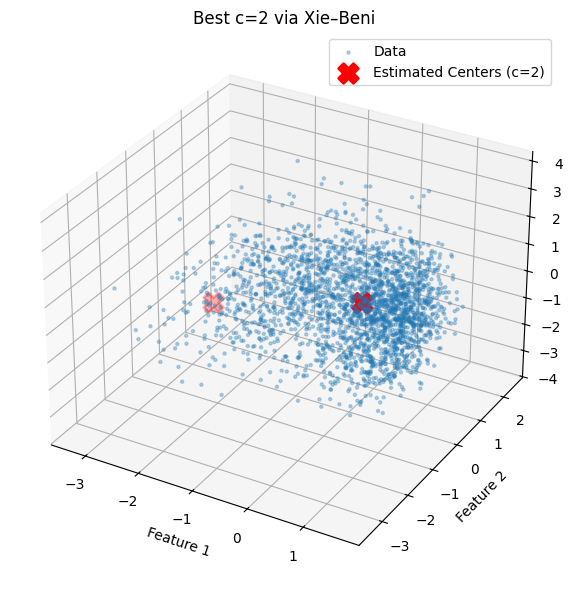

In [206]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# (D) Plot final result for the chosen best_c in 3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot data points
ax.scatter(array_scaled[:, 0], array_scaled[:, 1], array_scaled[:, 2],
           s=5, alpha=0.3, label="Data")

# Plot cluster centers
ax.scatter(best_result["centers"][:, 0],
           best_result["centers"][:, 1],
           best_result["centers"][:, 2],
           marker='X', s=200, linewidths=2, c='red',
           label=f"Estimated Centers (c={best_c})")

# Labels and title
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
ax.set_zlabel("Feature 3")
ax.set_title(f"Best c={best_c} via Xie–Beni")

ax.legend()
plt.tight_layout()
plt.show()

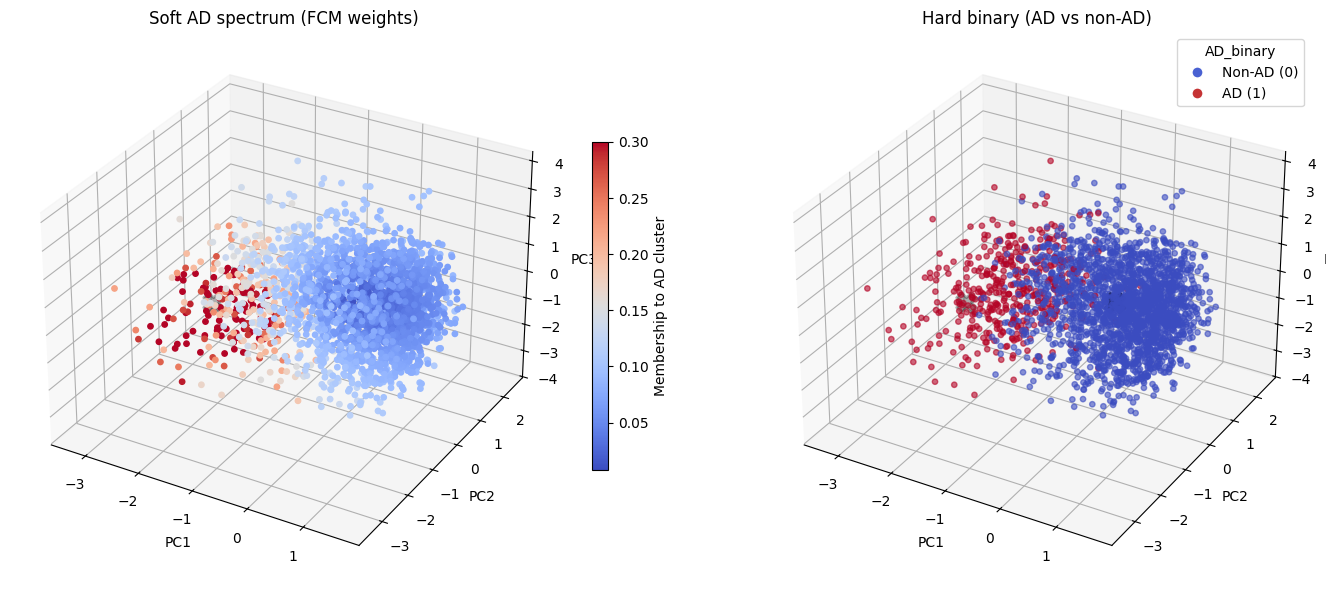

In [217]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.lines import Line2D

# Binary label (0=non-AD, 1=AD/Dementia)
df['AD_binary'] = df['cluster'].apply(lambda x: 1 if x in ['AD','Dementia'] else 0)

# Soft membership weight for AD-like cluster (assume last cluster is AD-like, adjust index if needed)
soft_weights_AD = best_result["U"][:, 0]    # use membership to AD cluster
soft_weights_AD = soft_weights_AD / np.max(soft_weights_AD)  # since max=0.2 → normalized to 1.0

fig = plt.figure(figsize=(14, 6))

### --- LEFT: soft spectrum ---
ax1 = fig.add_subplot(121, projection='3d')
sc1 = ax1.scatter(
    array_scaled[:, 0], array_scaled[:, 1], array_scaled[:, 2],
    c=soft_weights_AD, cmap='coolwarm', vmax=0.3, s=15, alpha=1
)
ax1.scatter(
    best_result["centers"][:, 0],
    best_result["centers"][:, 1],
    best_result["centers"][:, 2],
    marker='X', s=200, c='black', linewidths=2, label="Centers"
)
ax1.set_title("Soft AD spectrum (FCM weights)")
ax1.set_xlabel("PC1")
ax1.set_ylabel("PC2")
ax1.set_zlabel("PC3")
cbar1 = plt.colorbar(sc1, ax=ax1, shrink=0.6)
cbar1.set_label("Membership to AD cluster")

### --- RIGHT: original  ---


ax2 = fig.add_subplot(122, projection='3d')
sc2 = ax2.scatter(
    array_scaled[:, 0], array_scaled[:, 1], array_scaled[:, 2],
    c=df['AD_binary'], cmap='coolwarm', s=15, alpha=0.6
)
ax2.scatter(
    best_result["centers"][:, 0],
    best_result["centers"][:, 1],
    best_result["centers"][:, 2],
    marker='X', s=200, c='black', linewidths=2, label="Centers"
)
ax2.set_title("Hard binary (AD vs non-AD)")
ax2.set_xlabel("PC1")
ax2.set_ylabel("PC2")
ax2.set_zlabel("PC3")

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Non-AD (0)',
           markerfacecolor=plt.cm.coolwarm(0.05), markersize=8),
    Line2D([0], [0], marker='o', color='w', label='AD (1)',
           markerfacecolor=plt.cm.coolwarm(0.95), markersize=8)
]
ax2.legend(handles=legend_elements, title="AD_binary")

plt.tight_layout()
plt.show()


In [67]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

U=result_c['U']
# Normalize memberships
U_normalized = U / U.sum(axis=1, keepdims=True)
n_clusters = U_normalized.shape[1]

# Define 2D simplex (line segment)
C1 = np.array([0, 0])
C2 = np.array([1, 0])
corners = np.stack([C1, C2])
# Project memberships onto 2D line
points = U_normalized @ corners
# Color points by membership (AD = red, non-AD = blue)

# Map memberships to RGB colors
# AD (cluster 0) → red channel, non-AD (cluster 1) → blue channel
colors_rgb = np.zeros((U_normalized.shape[0], 3))
colors_rgb[:, 0] = U_normalized[:, 0]  # red
colors_rgb[:, 2] = U_normalized[:, 1]  # blue

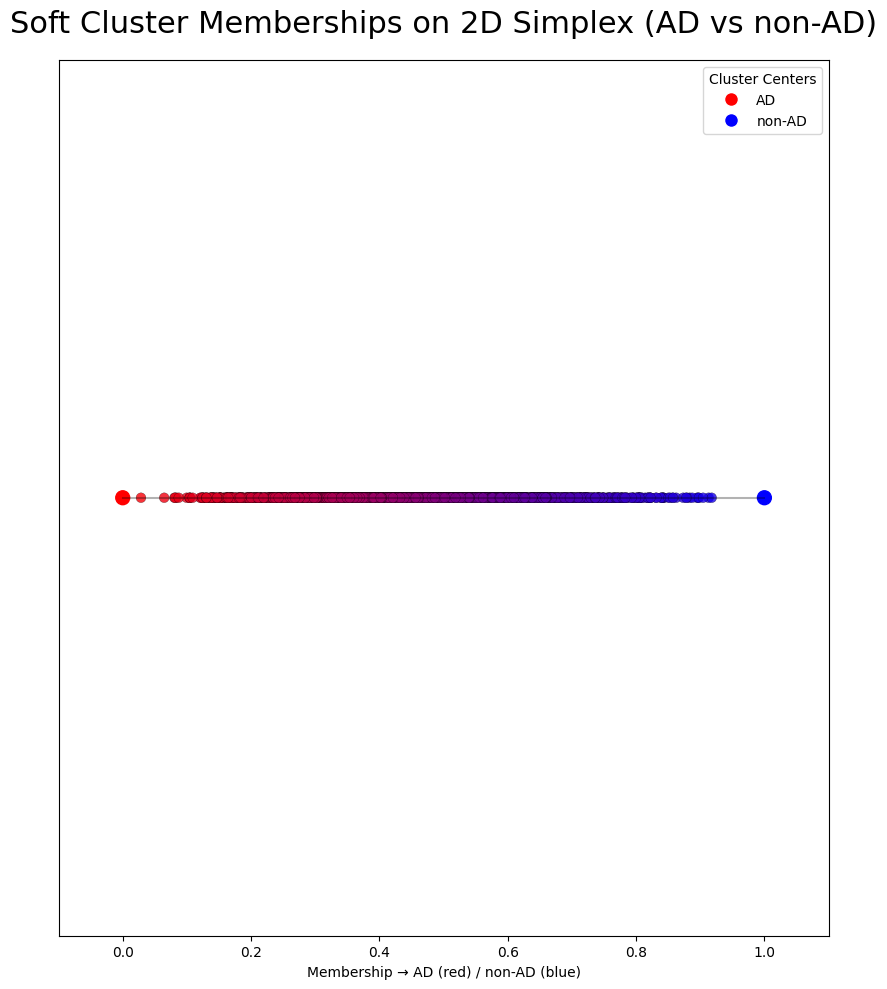

In [218]:
# Plot
fig, ax = plt.subplots(figsize=(8, 10))

# Draw line segment
ax.plot(corners[:, 0], corners[:, 1], 'k-', alpha=0.3)

# Plot cluster centers
ax.scatter(corners[:, 0], corners[:, 1],
           c=['red', 'blue'], s=100, label='Cluster Centers')

# Plot data points with soft membership coloring
ax.scatter(points[:, 0], points[:, 1],
           c=colors_rgb, s=50, alpha=0.8, edgecolor='k', linewidth=0.2)

ax.set_xlim(-0.1, 1.1)
ax.set_ylim(-0.1, 0.1)
ax.set_yticks([])  # hide y-axis
ax.set_xlabel('Membership → AD (red) / non-AD (blue)')
ax.set_title('Soft Cluster Memberships on 2D Simplex (AD vs non-AD)', fontsize = 22, pad=20)

# Legend
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='AD',
           markerfacecolor='red', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='non-AD',
           markerfacecolor='blue', markersize=10)
]
ax.legend(handles=legend_elements, loc='upper right', title='Cluster Centers')

plt.tight_layout()
plt.show()


# FCM vs GMM

In [ ]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score, accuracy_score
# ----------------------------
# Inputs
# ----------------------------
# array_scaled: standardized ADNI features (n_samples x n_features)
# best_result: WFCM output with keys "U" (membership) and "centers")
# df['AD_binary']: true AD/non-AD labels (0=non-AD, 1=AD)

wfcms_u = best_result["U"]  # soft membership matrix
n_samples, n_clusters_wfcm = wfcms_u.shape
wfcms_labels = np.argmax(wfcms_u, axis=1)  # hard labels

# ----------------------------
# Xie-Beni function
# ----------------------------
def xie_beni_index(data, membership, centroids):
    n_samples, n_clusters = membership.shape
    dist_matrix = np.linalg.norm(
        data[:, np.newaxis, :] - centroids[np.newaxis, :, :],
        axis=2
    )**2
    numerator = np.sum(membership * dist_matrix)
    min_dist = np.min([
        np.sum((centroids[i] - centroids[j])**2)
        for i in range(n_clusters) for j in range(i+1, n_clusters)
    ])
    return numerator / (n_samples * min_dist)

# ----------------------------
# Fit GMM with same number of clusters as WFCM
# ----------------------------
c_candidates = np.arange(2, 5) 
best_gmm = None
best_bic = np.inf

for c_val in c_candidates:
    print(f"\n--- Trying GMM with c = {c_val} ---")
    gmm = GaussianMixture(
        n_components=c_val,
        covariance_type="full",
        random_state=12,
        n_init=5,
        max_iter=300
    )
    gmm.fit(array_scaled)
    bic = gmm.bic(array_scaled)
    print(f"BIC for c={c_val}: {bic:.2f}")
    
    if bic < best_bic:
        best_bic = bic
        best_gmm = gmm

gmm_labels = best_gmm.predict(array_scaled)
n_clusters_gmm = best_gmm.n_components

# ----------------------------
# Create hard membership matrix for GMM
# ----------------------------
gmm_u = np.zeros((n_samples, n_clusters_gmm))
for i in range(n_clusters_gmm):
    gmm_u[:, i] = (gmm_labels == i).astype(float)

# ----------------------------
# Compute Xie-Beni
# ----------------------------
wfcms_centroids = np.dot(wfcms_u.T, array_scaled) / wfcms_u.sum(axis=0)[:, None]
xb_wfcm = xie_beni_index(array_scaled, wfcms_u, wfcms_centroids)
xb_gmm = xie_beni_index(array_scaled, gmm_u, best_gmm.means_)

# ----------------------------
# Compute ARI / Accuracy vs True Labels
# ----------------------------
true_labels = df['AD_binary'].values
# Identify AD-like cluster by overlap with true labels
AD_index_wfcm = np.argmax(np.dot(wfcms_u.T, true_labels))
AD_index_gmm = np.argmax(np.dot(gmm_u.T, true_labels))

wfcms_pred = np.argmax(wfcms_u, axis=1)
gmm_pred = np.argmax(gmm_u, axis=1)

ari_wfcm = adjusted_rand_score(true_labels, wfcms_pred)
ari_gmm = adjusted_rand_score(true_labels, gmm_pred)
acc_wfcm = accuracy_score(true_labels, wfcms_pred)
acc_gmm = accuracy_score(true_labels, gmm_pred)

# ----------------------------
# Print summary
# ----------------------------
print("\n--- Model Comparison ---")
print(f"BIC (GMM): {best_bic:.2f}")
print(f"Xie–Beni (WFCM): {xb_wfcm:.4f}")
print(f"Xie–Beni (GMM): {xb_gmm:.4f}")
print(f"ARI vs True Labels (WFCM): {ari_wfcm:.3f}")
print(f"ARI vs True Labels (GMM): {ari_gmm:.3f}")
print(f"Accuracy vs True Labels (WFCM): {acc_wfcm:.3f}")
print(f"Accuracy vs True Labels (GMM): {acc_gmm:.3f}")


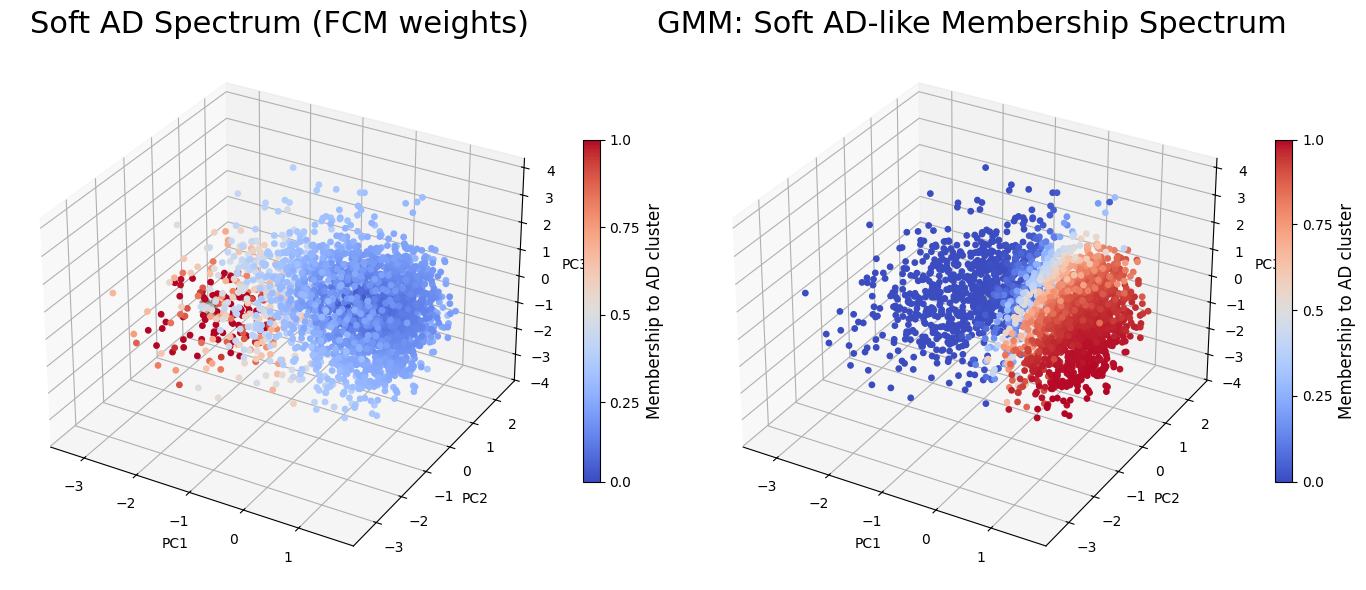

In [180]:
from mpl_toolkits.mplot3d import Axes3D


# --- Soft membership weights ---
soft_weights_AD = best_result["U"][:, 0]   # FCM membership to AD cluster
soft_weights_GMM = best_gmm.predict_proba(array_scaled)[:, 0]  # GMM membership (AD-like cluster)

# Consistent vmin/vmax range for fair comparison
vmin = min(soft_weights_AD.min(), soft_weights_GMM.min())
vmax = max(soft_weights_AD.max(), soft_weights_GMM.max())

fig = plt.figure(figsize=(14, 6))

# ====================================================
# LEFT: FCM soft membership spectrum
# ====================================================
ax1 = fig.add_subplot(121, projection='3d')
sc1 = ax1.scatter(
    array_scaled[:, 0], array_scaled[:, 1], array_scaled[:, 2],
    c=soft_weights_AD, cmap='coolwarm',
    vmin=soft_weights_AD.min(), vmax=0.2, s=15, alpha=1
)
ax1.scatter(
    best_result["centers"][:, 0],
    best_result["centers"][:, 1],
    best_result["centers"][:, 2],
    marker='X', s=200, c='black', linewidths=2, label="Centers"
)
ax1.set_title("Soft AD Spectrum (FCM weights)", fontsize=22)
ax1.set_xlabel("PC1"); ax1.set_ylabel("PC2"); ax1.set_zlabel("PC3")

# Adjust colorbar to look like 0–1 scale
cbar1 = plt.colorbar(sc1, ax=ax1, shrink=0.6)
cbar1.set_label("Membership to AD cluster", fontsize=12)
cbar1.set_ticks([soft_weights_AD.min(), 0.05, 0.1, 0.15, 0.2])
cbar1.set_ticklabels([0.0, 0.25, 0.5, 0.75, 1.0])

# ====================================================
# RIGHT: GMM soft membership spectrum
# ====================================================
ax2 = fig.add_subplot(122, projection='3d')
sc2 = ax2.scatter(
    array_scaled[:, 0], array_scaled[:, 1], array_scaled[:, 2],
    c=soft_weights_GMM, cmap='coolwarm', vmin=vmin, vmax=vmax, s=15, alpha=1
)
ax2.scatter(
    best_gmm.means_[:, 0], best_gmm.means_[:, 1], best_gmm.means_[:, 2],
    marker='X', s=200, c='black', linewidths=2, label="Centers"
)
ax2.set_title("GMM: Soft AD-like Membership Spectrum", fontsize=22)
ax2.set_xlabel("PC1"); ax2.set_ylabel("PC2"); ax2.set_zlabel("PC3")

cbar2 = plt.colorbar(sc2, ax=ax2, shrink=0.6)
cbar2.set_label("Membership to AD cluster", fontsize=12)
cbar2.set_ticks([soft_weights_GMM.min(), 0.25, 0.5, 0.75, soft_weights_GMM.max()])
cbar2.set_ticklabels([0.0, 0.25, 0.5, 0.75, 1.0])
plt.tight_layout()
plt.show()


In [53]:
# =============================================
# 8) PARAMETRIC BOOTSTRAP FOR c-CLUSTER MODEL
# =============================================
def sample_from_fit_ccluster(theta, N, iterations=30000, burn_in=0.2, proposal_std=1.0, seed=123):
    """
    Generate N synthetic samples from the fitted 4-cluster fuzzy model
    using Metropolis-Hastings.

    theta: dict with keys ["sigma","centers","m","w"]
    """
    sigma_syn = theta["sigma"]
    centers_syn = theta["centers"]
    w_syn = theta["w"]
    m_syn = theta["m"]
    # Just pick the first center as an initial point, or (0,0).
    initial_point = centers_syn[0]

    samples_mh, acc_rate = metropolis_hastings_ccluster(
        sigma_syn, centers_syn, m_syn, w_syn,
        initial_point=initial_point,
        iterations=iterations,
        proposal_std=proposal_std,
        burn_in=burn_in,
        seed=seed
    )

    if samples_mh.shape[0] > N:
        samples_mh = samples_mh[:N]
    return samples_mh


In [54]:

def parametric_bootstrap_cluster_c_p(
    fitted_result,
    N_original,
    B=50,
    proposal_samples=None,
    proposal_weights=None,
    max_iter=30,
    random_state=999,
    c_val = 2,
    d = 3
):
    """
    Parametric bootstrap for 3-cluster fuzzy model.

    1) Generate data from fitted distribution (theta_hat).
    2) Refit the 2-cluster model.
    3) Collect distribution of re-fitted parameters.
    """
    rng = np.random.RandomState(random_state)

    # Unpack final fitted params
    sigma_hat = fitted_result["sigma"]
    centers_hat = fitted_result["centers"]  # shape (c,2)
    w_hat = fitted_result["w"]              # shape (c,)
    m_hat = fitted_result["m"]

    # param vector length => 1 + 2*c + c = 7
    bootstrap_estimates = np.zeros((B, 1+ (d+1)*c_val))

    def flatten_params(sigma_val, centers_val, w_val):
        return np.concatenate(([sigma_val], centers_val.flatten(), w_val))

    orig_flat = flatten_params(sigma_hat, centers_hat, w_hat)
    print("\nOriginal final fit (flattened):\n", orig_flat)

    for b_i in range(B):
        # 1) Generate synthetic dataset
        seed_b = rng.randint(0, 999999)
        synthetic_data = sample_from_fit_ccluster(
            fitted_result,
            N=N_original,
            iterations=30000,
            burn_in=0.2,
            proposal_std=1.0,
            seed=seed_b
        )

        # 2) Refit
        refit = em_like_fuzzy_clustering_c_p(
            data=synthetic_data,
            proposal_samples=proposal_samples,
            proposal_weights=proposal_weights,
            m=m_hat,
            c = c_val,
            initial_sigma=sigma_hat,
            initial_centers=centers_hat,
            initial_w=w_hat,
            max_iter=max_iter,
            tol=1e-5
            #random_state=seed_b
        )

        sigma_b = refit["sigma"]
        centers_b = refit["centers"]
        w_b = refit["w"]

        bootstrap_estimates[b_i, :] = flatten_params(sigma_b, centers_b, w_b)

        print(f"[Bootstrap {b_i+1}/{B}]  sigma={sigma_b:.3f}, w={w_b}, centers=\n{centers_b}")

    return bootstrap_estimates

In [63]:
# -----------------------------------------
# D) Parametric Bootstrap for c=4
# -----------------------------------------
B = 50  # demo only; ideally 50 or 100
boot_estimates = parametric_bootstrap_cluster_c_p(
    fitted_result=result_c,
    N_original=data.shape[0],
    B=B,
    proposal_samples=samples_IS,
    proposal_weights=proposal_pdf,
    max_iter=20,
    random_state=999, 
    d = 3
)

d = 3
# E) Summarize the bootstrap
print("\n=== Bootstrap Summaries ===")
param_means = np.mean(boot_estimates, axis=0)
param_stds  = np.std(boot_estimates, axis=0)

# The order is [sigma, c1_x, c1_y, c2_x, c2_y, c3_x, c3_y, c4_x, c4_y, w1, w2, w3, w4]
names = ["sigma"] \
      + [f"c{j+1}_{ax}" for j in range(c_val) for ax in range(d)] \
      + [f"w{j+1}" for j in range(c_val)]

# names = ["sigma",
#             "c1_x","c1_y","c2_x","c2_y",
#             "w1","w2"]
for i, nm in enumerate(names):
    print(f"{nm}: mean={param_means[i]:.3f}, std={param_stds[i]:.3f}")

# 1D normal approx intervals
z = 1.96
ci_lo = param_means - z * param_stds
ci_hi = param_means + z * param_stds
print("\n95% CIs (normal approx):")
for i, nm in enumerate(names):
    print(f"{nm} => ({ci_lo[i]:.3f}, {ci_hi[i]:.3f})")


Original final fit (flattened):
 [ 3.55499305e-01  3.55963922e-01  1.87171616e-02  9.58415853e-04
 -2.37946471e+00 -3.81793977e-01 -1.90800418e-01  8.33097644e-01
  1.66902356e-01]
Iteration 1/20  NLL=2124.582288  Δ=inf
Iteration 2/20  NLL=1719.284080  Δ=4.05e+02
Iteration 3/20  NLL=1704.962331  Δ=1.43e+01
Iteration 4/20  NLL=1698.873099  Δ=6.09e+00
Iteration 5/20  NLL=1697.462247  Δ=1.41e+00
Iteration 6/20  NLL=1696.987425  Δ=4.75e-01
Iteration 7/20  NLL=1696.846857  Δ=1.41e-01
Iteration 8/20  NLL=1696.807862  Δ=3.90e-02
Iteration 9/20  NLL=1696.788683  Δ=1.92e-02
Iteration 10/20  NLL=1696.783853  Δ=4.83e-03
Iteration 11/20  NLL=1696.782143  Δ=1.71e-03
Iteration 12/20  NLL=1696.781925  Δ=2.19e-04
Iteration 13/20  NLL=1696.781672  Δ=2.52e-04
Iteration 14/20  NLL=1696.781399  Δ=2.73e-04
Iteration 15/20  NLL=1696.781410  Δ=1.08e-05
Iteration 16/20  NLL=1696.781520  Δ=1.10e-04
Iteration 17/20  NLL=1696.782299  Δ=7.79e-04
Iteration 18/20  NLL=1696.781805  Δ=4.94e-04
Iteration 19/20  NLL=1

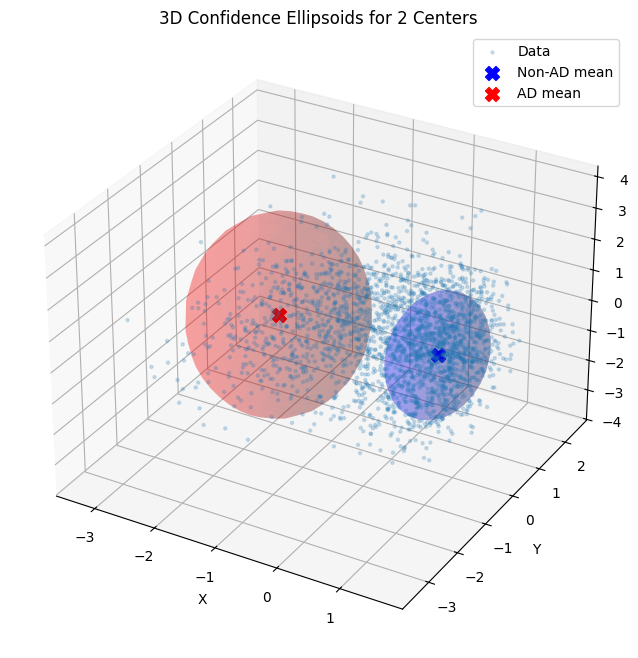

In [84]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import chi2


def plot_ellipsoid_3d(ax, mean, cov, chi2_val, color, alpha=0.2):
    """Plot a 3D ellipsoid given mean, covariance, and chi2 critical value."""
    # Eigen-decomposition of covariance
    eigvals, eigvecs = np.linalg.eigh(cov)

    # Radii of ellipsoid axes
    radii = np.sqrt(eigvals * chi2_val)

    # Parametric sphere
    u = np.linspace(0, 2*np.pi, 30)
    v = np.linspace(0, np.pi, 15)
    x = np.outer(np.cos(u), np.sin(v))
    y = np.outer(np.sin(u), np.sin(v))
    z = np.outer(np.ones_like(u), np.cos(v))
    sphere = np.stack((x, y, z), axis=-1)

    # Transform sphere → ellipsoid
    ellipsoid = sphere @ (eigvecs * radii) + mean

    ax.plot_surface(
        ellipsoid[..., 0], ellipsoid[..., 1], ellipsoid[..., 2],
        color=color, alpha=alpha, linewidth=0
    )

# --- Example usage ---
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

# Scatter data points
ax.scatter(array_scaled[:,0], array_scaled[:,1], array_scaled[:,2],
           s=5, alpha=0.2, label="Data")

# Covariance from bootstrap
cov_full = np.cov(boot_estimates.T)
mean_full = param_means

center_idxs = [(1,4), (4,7)]  # 3D centers for 2 clusters
cluster_colors = ['blue', 'red']
centroid_names = ['Non-AD', 'AD']

for j, (i_start, i_end) in enumerate(center_idxs):
    cov_j = cov_full[i_start:i_end, i_start:i_end]
    mean_j = mean_full[i_start:i_end]

    # Plot centroid
    ax.scatter(*mean_j, c=cluster_colors[j], marker='X', s=100,
               label=f"{centroid_names[j]} mean")

    # 95% confidence ellipsoid
    plot_ellipsoid_3d(ax, mean_j, cov_j, chi2_val=chi2.ppf(0.95,3),
                      color=cluster_colors[j], alpha=0.2)

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title("3D Confidence Ellipsoids for 2 Centers")
ax.legend()
plt.show()
